In [1]:
import pandas as np
import numpy as np

from scipy.io import loadmat
data = loadmat('ex3data1.mat')
data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

(-0.5, 399.5, 19.5, -0.5)

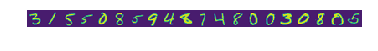

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt

sample = np.random.choice(X.shape[0], 20)
plt.imshow(X[sample,1:].reshape(-1,20).T)
plt.axis('off')

In [2]:
# data is a dictionary so df.head() not applied
# X , y are ndarrays so df.insert() not applied to add a column of ones
X = data['X']
y = data['y']

print(X.shape)
print(y.shape)
#print(y.max() - y.min() + 1)

(5000, 400)
(5000, 1)


In [3]:
# Adding a column of ones
m = X.shape[0]
print(m)

X = np.c_[np.ones((m,1)),X]
X.shape

5000


(5000, 401)

np.c_ concatenates along second axis ie; (5000, 1 + 400)  = (5000,401)

In [4]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [5]:
# Regularized Cost Function
def regcost(theta, X, y, lambdaa):
    z = np.dot(X, theta.reshape(-1,1)) # m = (5000,401) * (401,1) = (5000,1)
    h = sigmoid(z)
    J = (-1/len(y)) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) + (lambdaa/(2*len(y))) * np.sum(theta[1:] ** 2)
    return J

In [6]:
# Regularixed gradient
def RegGrad(theta, X, y, lambdaa):
    z = np.dot(X, theta.reshape(-1,1)) # m = (5000,1)
    h = sigmoid(z)
    error = (h - y)
    grad = (1/len(y)) * np.dot(X.T, error) +  (lambdaa / len(y)) * np.r_[[[0]],theta[1:].reshape(-1,1)]
    return grad.flatten()

#### Test cases for our regularized cost and gradient function

In [7]:
theta_test = np.array([-2,-1,1,2]) # Creating rank - 1 array of (4,)
#print(theta_t.shape)

t = np.arange(1,16).reshape(3, 5) / 10
v = t.T
X_test = np.c_[np.ones((5,1)), v]
#print(X_t)

y_test = np.array([[1], [0], [1], [0], [1]])
#print(y_t.shape)

lambdaa_test = 3

In [8]:
regcost(theta_test, X_test, y_test, lambdaa_test)

2.534819396109744

In [9]:
RegGrad(theta_test, X_test, y_test, lambdaa_test)

array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

### One - Vs - All Training

We initialize a matrix of zeros, theta_all, which holds all the trained parameters. Each row theta_all represents a class and the columns of theta_all represent all the parameters $\theta_0 \dots \theta_n$ associated with predictions for that class.

One-vs-all classification is implemented by iteratively training the parameters for each class k. In each iteration, the use of the grdtruth vector ensures all instances of k in our training dataset are given the label 1, while all other instances that are not k are given the label 0. This is the essence of the one-vs-all method.

Choice of optimization algorithm used is specified through a string following the choices supported by scipy.optimize.minimize.

The grdtruth vector for each iteration is passed into the optimization routine as the vector of class labels. The theta_all array is indexed row by row in each iteration to first pass a vector of 0 (as the parameters are first initialized to zeros) into the optimization routine, and the trained parameters then being stored directly in that same row, overwriting the old zeros in place.

Regularization parameter $\lambda$ is kept at a constant value of 0.1 through all iterations.

The matrix of trained parameters is returned at the end of training.

In [10]:
from scipy.optimize import minimize

# One - Vs - All Classifier
def OneVsAll(X, y , num_labels, opt_method):
    
    all_theta = np.zeros((num_labels, X.shape[1])) # (10,401)
    
    initial_theta = np.zeros(X.shape[1]) # (401,)
    
    # class k has values from 1 to 10, where digit '0' is mapped to label 10 to avoid confusion with octave indexing.
    for k in range(1, num_labels + 1):
        # y contains values from 1 to 10.
        # In each iteration, the use of y_bool vector ensures all instances of of k in our training dataset are given the label 1, 
        # while all other instances that are not k are given the label 0. This is the essence of the one-vs-all method. 
        y_bool = np.where(y == k, 1, 0)
        
        res = minimize(regcost, x0 = initial_theta, args = (X, y_bool, 0.1), method = opt_method, jac = RegGrad)
        
        theta_optimized = res.x 
        
        # i = 0; copy theta_optimized vector into 1st row of all_theta matrix
        # i = 1; copy theta_optimized vector into 2nd row of all_theta matrix and so on 
        # In python index begins from 0, as there are 10 classes so iterating from 0, ....,9
        all_theta[k-1, :] = theta_optimized
        
    return (all_theta)

In [11]:
# Optimization performed using Conjugate Gradient
all_theta_optimized_CG = OneVsAll(X, y, 10, 'CG')

# Optimization performed using BFGS
all_theta_optimized_bfgs = OneVsAll(X, y, 10, 'BFGS')

### One - Vs - All Prediction
We now use our trained classifiers to predict the digit contained in a given image.

#### predictOnevsAll() implementation notes
We can vectorize the prediction computation after a transpose of the matrix containining all of our trained parameters for every class $\theta_0, \theta_1 \dots \theta_9$, called theta_all. We can then multiply the design/model matrix, X_bias with theta_all, and apply the sigmoid() function to every element.

Each row of the resulting matrix will represent the probability values associated with each class for each image in our training dataset. The class whose prediction has the highest probability value will be the class that this image is predicted to belong to. Taking np.argmax along axis=1 ensures that the index position of the largest probability value for each row (and hence each image) is returned.

Lastly, adding one to the resulting indices will give us the predicted class, by ensuring that we match the MATLAB/Octave convention where indexing begins at 1 and being consistent with class labels ranging from 1 to 10 as in the provided global ground truth vector y.

In [12]:
def predictOneVsAll(X, theta):
    z = np.dot(X, theta.T)
    probability = sigmoid(z)
    
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return np.mean(np.argmax(probability, axis=1) + 1 == y.ravel()) * 100

In [13]:
predictOneVsAll(X,all_theta_optimized_CG)

96.46000000000001

In [14]:
predictOneVsAll(X,all_theta_optimized_bfgs)

96.48

Let's see our prediction using TNC and Newton-CG

In [15]:
all_theta_optimized_tnc = OneVsAll(X, y, 10, 'TNC')
predictOneVsAll(X,all_theta_optimized_tnc)

96.46000000000001

In [16]:
all_theta_optimized_Newton_CG = OneVsAll(X, y, 10, 'Newton-CG')
predictOneVsAll(X,all_theta_optimized_Newton_CG)

96.46000000000001

### Multiclass Logistic Regression with Scikit - Learn

In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C = 10, penalty = 'l2', solver = 'liblinear')

# # Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:], y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
pred2 = clf.predict(X[:,1:])
acc = np.mean(pred2 == y.ravel()) * 100
acc

96.5

### Multi-class Classification with Neural Network

In [19]:
# Loading weights dictionary
Weights = loadmat('ex3weights.mat')
Weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [20]:
theta1 , theta2 = Weights['Theta1'], Weights['Theta2']
print(theta1.shape)
print(theta2.shape)

(25, 401)
(10, 26)


In [40]:
def predict(theta1, theta2, X):
    
    # Mapping from layer 1 to layer 2
    a1 = X # (5000,401); We have already added one column
    z2 = np.dot(a1, theta1.T)
    a2 = sigmoid(z2) # (5000,25)

    # Mapping from layer 2 to layer 3
    # Adding a column of ones
    a2 = np.c_[np.ones((z2.shape[0], 1)), a2]
    z3 = np.dot(a2, theta2.T)
    a3 = sigmoid(z3)
    
    return (np.argmax(a3, axis = 1) + 1)

In [48]:
p = predict(theta1, theta2, X)
acc = np.mean(p == y.ravel()) * 100
print('Training set accuracy : ' + str(acc) + ' %')

Training set accuracy : 97.52 %
